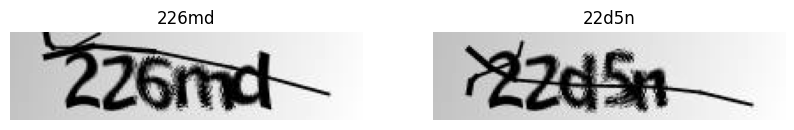

In [5]:
import os
import numpy as np
import cv2
import string
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
from sklearn.utils import shuffle


# Define the folder path
folder_path = 'samples'

# Initialize lists for images and labels
images = []
labels = []

# Load images and labels
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Load image
        img = cv2.imread(os.path.join(folder_path, filename))
        # Convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Append to lists
        images.append(gray_img)
        labels.append(os.path.splitext(filename)[0])

# Display two images with their labels
plt.figure(figsize=(10, 5))

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(labels[i])
    plt.axis('off')

plt.show()

In [6]:
#Init main values
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)

In [7]:
def preprocess_data():
    n_samples = len(os.listdir(folder_path))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir(folder_path)):
        # Read image as grayscale
        img = cv2.imread(os.path.join(folder_path, pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            if img is not None:
                img = img / 255.0
                img = np.reshape(img, (50, 200, 1))
                # Define targets and code them using OneHotEncoding
                targs = np.zeros((5, num_symbols))
                for j, l in enumerate(pic_target):
                    ind = symbols.find(l)
                    targs[j, ind] = 1
                X[i] = img
                y[:, i] = targs
    
    # Shuffle the data
    X, y = shuffle(X, y.transpose(1, 0, 2), random_state=42)
    y = y.transpose(1, 0, 2)
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_val, y_val = X[970:1050], y[:, 970:1050]
X_test, y_test = X[1050:], y[:, 1050:]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train label vector shape: {y_train.shape}")
print(f"Validation label vector shape: {y_val.shape}")
print(f"Test label vector length: {y_test.shape}")

Training set shape: (970, 50, 200, 1)
Validation set shape: (80, 50, 200, 1)
Test set shape: (20, 50, 200, 1)
Train label vector shape: (5, 970, 36)
Validation label vector shape: (5, 80, 36)
Test label vector length: (5, 20, 36)


In [9]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=5*["accuracy"])
    return model

model=create_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 50, 200,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 50, 200,   │        160 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 25, 100,   │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 25, 100,   │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 13, 50,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 13, 50,    │      9,248 │ max_pooling2d_7[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 50,    │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 7, 25, 32) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 5600)      │          0 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │    358,464 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │    358,464 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 64)        │    358,464 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │    358,464 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │    358,464 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ dense_26[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_28[0][0]  

 Total params: 1,818,196 (6.94 MB)

 Trainable params: 1,818,132 (6.94 MB)

 Non-trainable params: 64 (256.00 B)

In [10]:
# Create the model
history = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=30,verbose=1, validation_split=0.2)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - dense_21_accuracy: 0.0459 - dense_21_loss: 3.7293 - dense_23_accuracy: 0.0429 - dense_23_loss: 3.7858 - dense_25_accuracy: 0.0333 - dense_25_loss: 4.0046 - dense_27_accuracy: 0.0394 - dense_27_loss: 3.7615 - dense_29_accuracy: 0.0507 - dense_29_loss: 3.9915 - loss: 19.2741 - val_dense_21_accuracy: 0.0309 - val_dense_21_loss: 3.5588 - val_dense_23_accuracy: 0.0619 - val_dense_23_loss: 3.5333 - val_dense_25_accuracy: 0.0412 - val_dense_25_loss: 3.5321 - val_dense_27_accuracy: 0.0670 - val_dense_27_loss: 3.5541 - val_dense_29_accuracy: 0.0773 - val_dense_29_loss: 3.5623 - val_loss: 17.7289
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - dense_21_accuracy: 0.0785 - dense_21_loss: 3.4880 - dense_23_accuracy: 0.0664 - dense_23_loss: 3.3791 - dense_25_accuracy: 0.0684 - dense_25_loss: 3.3265 - dense_27_accuracy: 0.0763 - dense_27_loss: 3.5079 - dense_29_accuracy: 0.0841 - dense_29_loss: 3.4858 - loss: 17.1869 - val_dense_21_accuracy: 0

Accuracy: 92.00%


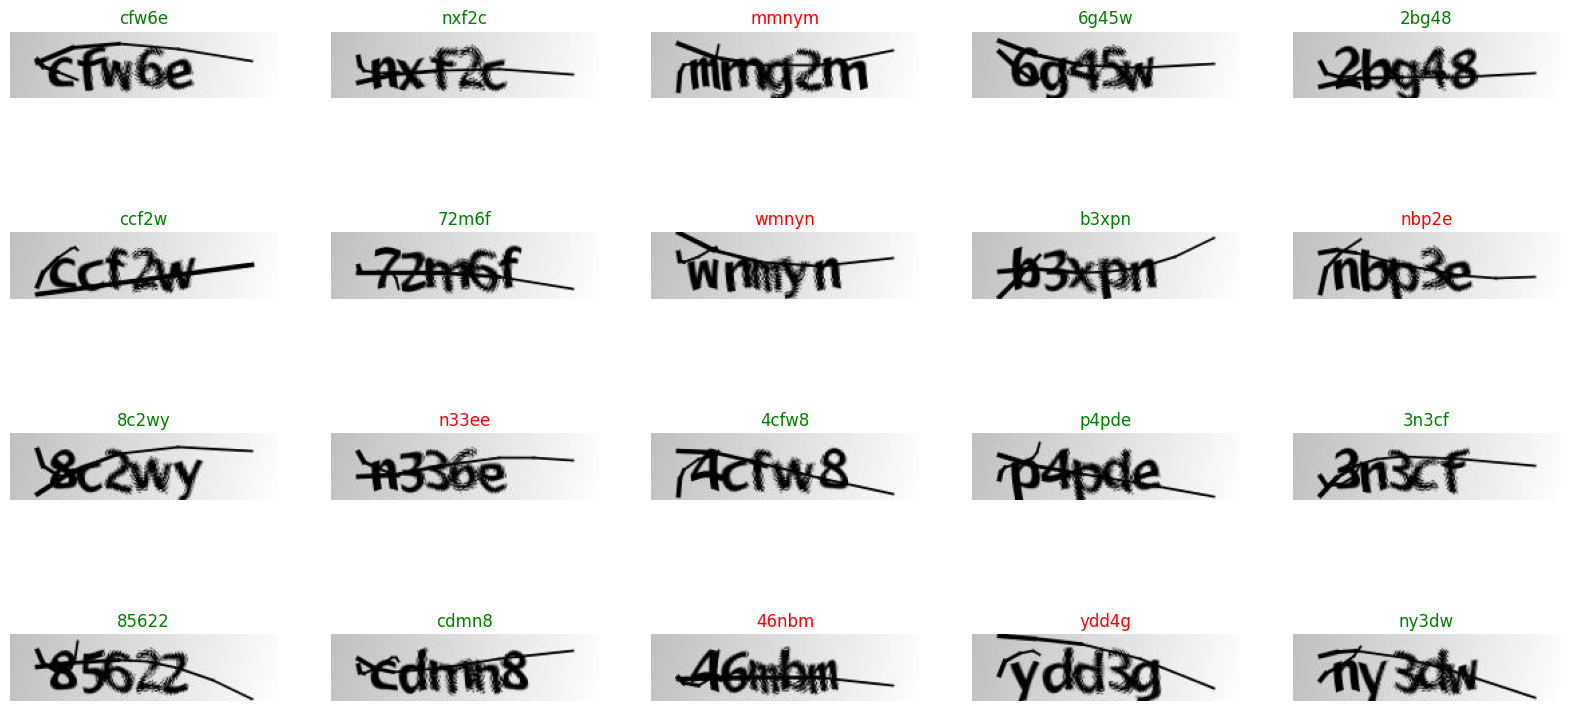

In [11]:
# Predict, display images and calculate accuracy for 20 images from X_test
plt.figure(figsize=(20, 10))

correct_predictions = 0
total_predictions = 20 * 5  # 20 images, each with 5 characters

for i in range(20):
    # Predict image
    img = X_test[i]
    res = np.array(model.predict(img[np.newaxis, :, :, :], verbose=0))
    ans = np.reshape(res, (5, 36))
    l_ind = [np.argmax(a) for a in ans]
    capt = ''.join([symbols[l] for l in l_ind])
    
    # Compare with true label
    true_label = ''.join([symbols[np.argmax(y_test[j, i])] for j in range(5)])
    correct_predictions += sum([1 for a, b in zip(capt, true_label) if a == b])
    
    # Display the image with predicted label and title color based on correctness
    plt.subplot(4, 5, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(capt, color='green' if capt == true_label else 'red')
    plt.axis('off')

# Calculate and print accuracy
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100:.2f}%")

plt.show()

Let's try to improve the results